In [77]:
import numpy as np
import pandas as pd

import os
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [78]:
import pandas as pd

# Step 1: Read the input CSV file into a pandas DataFrame
input_file = '/content/GOOG.csv'  # Replace with your actual input file path
df = pd.read_csv(input_file)

# Step 2: Convert 'date' column to datetime format if it's not already
df['date'] = pd.to_datetime(df['date'])

# Step 3: Set 'date' column as the index of the DataFrame (required for interpolation)
df.set_index('date', inplace=True)

# Step 4: Resample to 1-hour intervals and interpolate missing values
df_interpolated = df.resample('1H').interpolate(method='linear')

# Step 5: Reset index to convert 'date' back to a column
df_interpolated.reset_index(inplace=True)

# Step 6: Save the interpolated data to a new CSV file
output_file = 'interpolated_data_1_hour.csv'  # Replace with your desired output file path
df_interpolated.to_csv(output_file, index=False)

print(f"Interpolated data saved to {output_file}")


Interpolated data saved to interpolated_data_1_hour.csv


In [79]:
df = pd.read_csv('/content/interpolated_data_1_hour.csv', parse_dates=['date'])
print(df)

                           date symbol        close         high          low  \
0     2016-06-14 00:00:00+00:00   GOOG   718.270000   722.470000   713.120000   
1     2016-06-14 01:00:00+00:00    NaN   718.297083   722.491250   713.294583   
2     2016-06-14 02:00:00+00:00    NaN   718.324167   722.512500   713.469167   
3     2016-06-14 03:00:00+00:00    NaN   718.351250   722.533750   713.643750   
4     2016-06-14 04:00:00+00:00    NaN   718.378333   722.555000   713.818333   
...                         ...    ...          ...          ...          ...   
43748 2021-06-10 20:00:00+00:00    NaN  2515.208333  2526.368333  2497.575000   
43749 2021-06-10 21:00:00+00:00    NaN  2514.888750  2526.523750  2497.753750   
43750 2021-06-10 22:00:00+00:00    NaN  2514.569167  2526.679167  2497.932500   
43751 2021-06-10 23:00:00+00:00    NaN  2514.249583  2526.834583  2498.111250   
43752 2021-06-11 00:00:00+00:00   GOOG  2513.930000  2526.990000  2498.290000   

              open     volu

In [80]:
test_data = scaled_data[-prediction_days:]  # Take the last 'prediction_days' as test data
x_test = []
y_test = []

# Iterate over the test data correctly
for x in range(prediction_days, len(scaled_data)):
    x_test.append(scaled_data[x-prediction_days:x, :])
    y_test.append(scaled_data[x, :])

In [81]:
def load_data(company, start, end):

    dataframe = df.copy()
    if 'Symbol' in dataframe.columns:
        dataframe = dataframe.loc[dataframe.Symbol == company, :]
    else:
        print("Warning: 'Symbol' column not found in DataFrame. Returning the entire DataFrame.")
    # The following line caused the error, it's been commented out
    # dataframe = dataframe.loc[dataframe.Name == company, :]
    # Convert start and end to timezone-aware datetime objects, assuming 'date' column is in UTC
    start = pd.Timestamp(start).tz_localize('UTC')
    end = pd.Timestamp(end).tz_localize('UTC')
    dataframe = dataframe.loc[(dataframe['date'] > start) & (dataframe['date'] < end), :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'close'})
    return dataframe

In [82]:
import pandas as pd
import datetime as dt

def load_data(company, start, end):
    # Load the data
    dataframe = pd.read_csv('/content/interpolated_data_1_hour.csv') # Verify this file path

    # Check if 'date' column exists and is in datetime format
    if 'date' in dataframe.columns:
        dataframe['date'] = pd.to_datetime(dataframe['date'])
    else:
        print("Error: 'date' column not found in DataFrame.")
        return None  # Handle the error appropriately

    # Filter data based on start and end dates
    start = pd.Timestamp(start).tz_localize('UTC')
    end = pd.Timestamp(end).tz_localize('UTC')
    dataframe = dataframe.loc[(dataframe['date'] > start) & (dataframe['date'] < end), :]

    # Rename 'Closing_Price' column to 'close' if it exists
    if 'Closing_Price' in dataframe.columns:
        dataframe = dataframe.rename(columns = {'Closing_Price': 'high'})

    return dataframe

COMPANY = 'GOOG'
START_DATE = dt.datetime(2016,1,1,0,0)
END_DATE = dt.datetime(2021,1,1,0,0)

START_DATE_TEST = END_DATE
data = load_data(company = COMPANY,
                 start = START_DATE,
                 end = END_DATE)

print(data.head()) # Print the first few rows to verify data

                       date symbol       close       high         low  \
0 2016-06-14 00:00:00+00:00   GOOG  718.270000  722.47000  713.120000   
1 2016-06-14 01:00:00+00:00    NaN  718.297083  722.49125  713.294583   
2 2016-06-14 02:00:00+00:00    NaN  718.324167  722.51250  713.469167   
3 2016-06-14 03:00:00+00:00    NaN  718.351250  722.53375  713.643750   
4 2016-06-14 04:00:00+00:00    NaN  718.378333  722.55500  713.818333   

      open     volume    adjClose    adjHigh      adjLow  adjOpen  adjVolume  \
0  716.480  1306065.0  718.270000  722.47000  713.120000  716.480  1306065.0   
1  716.585  1302250.5  718.297083  722.49125  713.294583  716.585  1302250.5   
2  716.690  1298436.0  718.324167  722.51250  713.469167  716.690  1298436.0   
3  716.795  1294621.5  718.351250  722.53375  713.643750  716.795  1294621.5   
4  716.900  1290807.0  718.378333  722.55500  713.818333  716.900  1290807.0   

   divCash  splitFactor  
0      0.0          1.0  
1      0.0          1.0  
2 

In [83]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['high'].values.reshape(-1,1))

In [85]:
# Set the number of days used for prediction
prediction_days = 60

# Initialize empty lists for training data input and output
x_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_data)):
    # Append the previous 'prediction_days' values to x_train
    x_train.append(scaled_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [86]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, BatchNormalization
from keras.regularizers import L2

def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """

    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, return sequences, and L2 regularization
    model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1), kernel_regularizer=L2(0.01)))
    model.add(BatchNormalization())

    # Add a second LSTM layer with 50 units, return sequences, and L2 regularization
    model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=L2(0.01)))
    model.add(BatchNormalization())

    # Add a third LSTM layer with 50 units and L2 regularization
    model.add(LSTM(units=50, kernel_regularizer=L2(0.01)))
    model.add(BatchNormalization())

    # Add a dense output layer with one unit
    model.add(Dense(units=1))

    return model

In [87]:
model = LSTM_model()
model.summary()
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 60, 50)            10400     
                                                                 
 batch_normalization_9 (Bat  (None, 60, 50)            200       
 chNormalization)                                                
                                                                 
 lstm_32 (LSTM)              (None, 60, 50)            20200     
                                                                 
 batch_normalization_10 (Ba  (None, 60, 50)            200       
 tchNormalization)                                               
                                                                 
 lstm_33 (LSTM)              (None, 50)                20200     
                                                                 
 batch_normalization_11 (Ba  (None, 50)              

In [88]:
# Callbacks

# Save weights only for best model
checkpointer = ModelCheckpoint(
    filepath = 'weights_best.hdf5',
    verbose = 2,
    save_best_only = True
)

model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size = 32,
    callbacks = [checkpointer]
)

Epoch 1/10
1245/1245 [==============================] - ETA: 0s - loss: 0.5432

1245/1245 [==============================] - 189s 143ms/step - loss: 0.5432
Epoch 2/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0767

1245/1245 [==============================] - 158s 127ms/step - loss: 0.0767
Epoch 3/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0226

1245/1245 [==============================] - 163s 131ms/step - loss: 0.0226
Epoch 4/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0074

1245/1245 [==============================] - 151s 121ms/step - loss: 0.0074
Epoch 5/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0033

1245/1245 [==============================] - 128s 103ms/step - loss: 0.0033
Epoch 6/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0023

1245/1245 [==============================] - 125s 100ms/step - loss: 0.0023
Epoch 7/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0021

1245/1245 [==============================] - 126s 101ms/step - loss: 0.0021
Epoch 8/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0020

1245/1245 [==============================] - 124s 99ms/step - loss: 0.0020
Epoch 9/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0019

1245/1245 [==============================] - 125s 100ms/step - loss: 0.0019
Epoch 10/10
1245/1245 [==============================] - ETA: 0s - loss: 0.0038

1245/1245 [==============================] - 124s 99ms/step - loss: 0.0038


In [89]:
test_data = load_data(
    company=COMPANY,
    start=START_DATE_TEST,   # Load test data for the specified company and date range
    end=dt.datetime.now()
)

actual_prices = test_data['high'].values

total_dataset = pd.concat((data['high'], test_data['high']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values

model_inputs = model_inputs.reshape(-1, 1)

model_inputs = scaler.transform(model_inputs)

In [90]:
x_test = []

for x in range(prediction_days, len(model_inputs)):

    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)  # Converting the x_test list to a numpy array

x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)  # Generate price predictions using the LSTM model

predicted_prices = scaler.inverse_transform(predicted_prices)

121/121 [==============================] - 15s 85ms/step


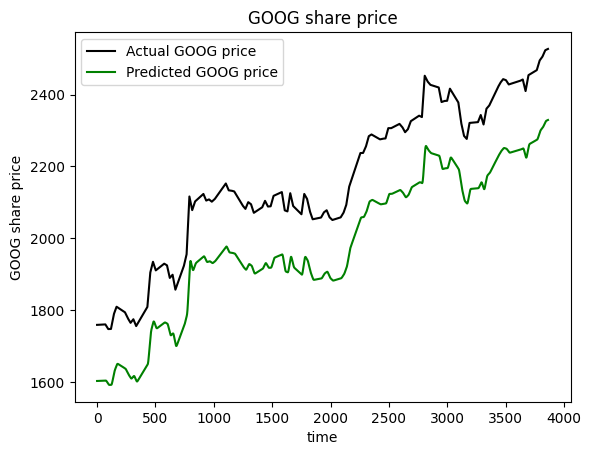

In [61]:
plt.plot(actual_prices, color='black', label=f"Actual {COMPANY} price") #1

plt.plot(predicted_prices, color='green', label=f"Predicted {COMPANY} price") #2

plt.title(f"{COMPANY} share price")
plt.xlabel("time")                    #3
plt.ylabel(f"{COMPANY} share price")

plt.legend()    #4
plt.show()

In [91]:
# Extract the last 'prediction_days' values from the model inputs
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]

# Convert the real_data list to a numpy array
real_data = np.array(real_data)

# Reshape real_data to a 3D array with the appropriate dimensions for the LSTM model
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

# Generate a prediction using the LSTM model with the real_data input
prediction = model.predict(real_data)

# Invert the scaling applied to the prediction to obtain the actual value
prediction = scaler.inverse_transform(prediction)

# Print the prediction result to the console
print(f"Prediction: {prediction[0][0]}")

1/1 [==============================] - 1s 1s/step
Prediction: 2547.576171875


In [92]:
# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(actual_prices - predicted_prices))

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((actual_prices - predicted_prices) / actual_prices)) * 100

# Calculate accuracy as (100 - MAPE)
accuracy = 100 - mape

print(f"Accuracy: {accuracy:.2f}%")


Accuracy: 88.57%


In [93]:
from sklearn.metrics import f1_score, recall_score, precision_score, roc_curve, auc

# Assuming 'actual_prices' contains true labels (0 or 1 for price increase/decrease)
# and 'predicted_prices' contains predicted probabilities
predicted_labels = (predicted_prices > np.roll(predicted_prices, 1))[1:]  # Convert predictions to binary labels
actual_labels = (actual_prices > np.roll(actual_prices, 1))[1:]

f1 = f1_score(actual_labels, predicted_labels)
recall = recall_score(actual_labels, predicted_labels)*100
precision = precision_score(actual_labels, predicted_labels)

print(f"F1 Score: {f1}")
print(f"Recall: {recall:.2f}%")
print(f"Precision: {precision}")

F1 Score: 0.9148110316649642
Recall: 90.61%
Precision: 0.9236798679867987


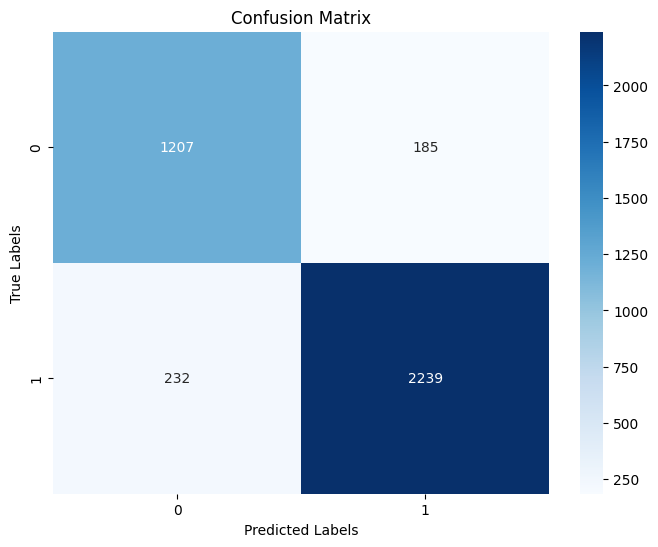

In [94]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'actual_labels' and 'predicted_labels' are defined as in the previous code
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()
